## Part 3: Machine Learning with Clustering

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import rcParams
import seaborn as sns

%matplotlib inline

sns.set_style("darkgrid")
#sns.set(rc={"figure.dpi":600, 'savefig.dpi':600})
params = {'axes.titlesize': 18.0, 
          'axes.labelsize': 16.0, 
          'legend.fontsize': 16.0,
          'xtick.labelsize': 12.0,        
          'ytick.labelsize': 12.0}
plt.rcParams.update(params)

from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import KMeans
from sklearn import metrics

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings("ignore")

In [2]:
customer = pd.read_csv('EDACustomer.csv').drop('Unnamed: 0', axis = 1)
offer = pd.read_csv('EDAOffer.csv').drop('Unnamed: 0', axis = 1)
transcript = pd.read_csv('EDATranscript.csv').drop('Unnamed: 0', axis = 1)

### Customer Characteristics
Before clustering, the customer and transcript datasets need to be combined so that the customer behaviors can be grouped.

In [3]:
# Creating an empty dataframe
customer_behaviors = pd.DataFrame(columns = ['person', 'received', 
                                            'viewed', 'completed', 'transactions'])

In [4]:
# The customers with NaN for income and gender were dropped from the customer 
# dataset in part 1, so the list of the ids currently in the customer dataset
# can be used to keep only the non null ids in transcript 
not_null_ids = customer['id']
filtered_transcript = transcript[transcript['person'].isin(not_null_ids)].reset_index(drop = True)

# And then added to customer_behaviors
customer_behaviors['person'] = filtered_transcript.value_counts('person').sort_index().index.values
customer_behaviors.set_index('person', inplace = True)

In [5]:
# Getting counts of each offer event by each customer 
filtered_transcript = filtered_transcript.sort_values('person')
grouped_transcript = filtered_transcript.groupby(['person', 'event']).count()

In [6]:
# Now filling in received, viewed, completed, and transactions 
for person_id in customer_behaviors.index.values:
    if (person_id, 'offer received') in list(grouped_transcript.index.values):
        customer_behaviors.loc[person_id, 'received'] = grouped_transcript.loc[(person_id, 'offer received'), 'key_id']
    if (person_id, 'offer viewed') in list(grouped_transcript.index.values):
        customer_behaviors.loc[person_id, 'viewed'] = grouped_transcript.loc[(person_id, 'offer viewed'), 'key_id']
    if (person_id, 'offer completed') in list(grouped_transcript.index.values):
        customer_behaviors.loc[person_id, 'completed'] = grouped_transcript.loc[(person_id, 'offer completed'), 'key_id']
    if (person_id, 'transaction') in list(grouped_transcript.index.values):
        customer_behaviors.loc[person_id, 'transactions'] = grouped_transcript.loc[(person_id, 'transaction'), 'key_id']
    

In [7]:
# Saving this since the above code chunk to over 4 minutes :) 
#customer_behaviors.to_csv('customer_behaviors.csv')

Now that we have a dataset with customer behaviors, we can find out how much each customer spent with value_id

In [8]:
x = filtered_transcript[filtered_transcript['event'] == 'transaction']
x['value_id'] = x['value_id'].astype(float)

# Calculating how much money each customer spent 
money_spent = x[x['event'] == 'transaction'].groupby('person').agg({'value_id': 'sum'})

# And adding money_spent to customer_behaviors
customer_behaviors['money_spent'] = money_spent

### Analysis of customer_behavior

In [9]:
customer_behaviors.isna().sum()

received           5
viewed           150
completed       2839
transactions     333
money_spent      333
dtype: int64

From above, we can see that: 
- 5 customers did not receive an offer
- 150 customers did not view the offer
- 2839 customers did not complete the offer
- 333 customers did not make any purchases nor did they spend any money

We'll replace NaNs with 0s in the customer_behavior dataset.

In [10]:
# Filling NaN
customer_behaviors.fillna(0, inplace = True)

# And keeping a copy
#customer_behavior_received = customer_behavior.copy()


#### Outliers

In [11]:
customer_behaviors['money_spent'].describe()

count    14825.000000
mean       117.028155
std        129.965016
min          0.000000
25%         31.450000
50%         87.040000
75%        160.900000
max       1608.690000
Name: money_spent, dtype: float64

The 0.75 quantile is only $160, while the maximum is $1608. This means that there are some significant outliers that are spending way more than the majoritiy of the customers. We can remove the top 2.5 % of spenders. 

In [12]:
# Removing rows with customers who's spending falls into the top 2.5%
q = customer_behaviors['money_spent'].quantile(0.975)

top_spenders_outliers = customer_behaviors[customer_behaviors['money_spent'] >= q]

customers_to_keep = customer_behaviors[customer_behaviors['money_spent'] < q]

print('Number of rows removed:', top_spenders_outliers.shape[0])

Number of rows removed: 371


In [13]:
# Keeping unaltered copy 
filtered_customers = customers_to_keep.copy()

Before scaling the data for clustering, the received column needs to be dropped from the customer_behavior data. This is because the customer did not decided whether or not to receive the offer. Starbucks decided who to send the offers too. 

In [14]:
clean_customers = filtered_customers.drop('received', axis = 1)
clean_customers.head(5)

,viewed,completed,transactions,money_spent
person,,,,
0009655768c64bdeb2e877511632db8f,4,3,8,127.60
0011e0d4e6b944f998e987f904e8c1e5,5,3,5,79.46
0020c2b971eb4e9188eac86d93036a77,3,3,8,196.86
0020ccbbb6d84e358d3414a3ff76cffd,4,3,12,154.05
003d66b6608740288d6cc97a6903f4f0,4,3,18,48.34


#### Scaling

In [15]:
sc = StandardScaler().fit(clean_customers)
scaled = sc.transform(clean_customers)
scaled_features = pd.DataFrame(data = scaled, 
                               columns = clean_customers.columns.values)

****
## Clustering 
Yay! Finally to the machine learning. <br>

**Before** we can actually create the clusters, we're going to find the ideal amount of clusters (k).

In [19]:
df_features = scaled_features
wcss = []
sil_score = []
max_clusters = 10

for k in range(1, max_clusters):
    kmeans = KMeans(n_clusters = k, random_state = 10)
    kmeans.fit(df_features)
    # calculate wcss for the Elbow Method 
    # and converting the data to a dataframe for plotting
    wcss.append(kmeans.inertia_)
    
    # calculate the mean Silhouette coefficient
    if k >= 2:
        labels = kmeans.labels_
        # and converting the data to a dataframe for plotting
        sil_score.append(metrics.silhouette_score(df_features, labels))

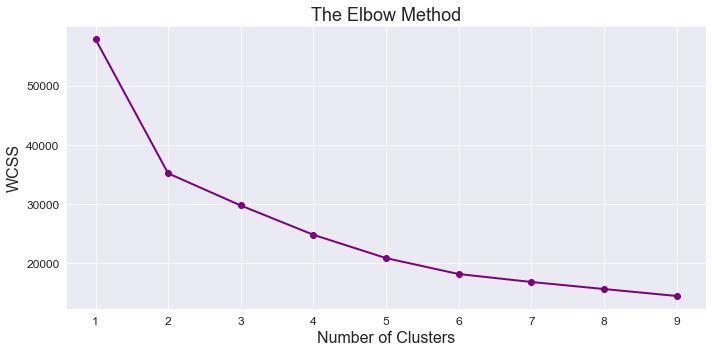

In [21]:
## Elbow
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(np.arange(1, max_clusters), wcss, marker = 'o', lw = 2, color = 'purple')
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('WCSS')
ax.set_title('The Elbow Method')

plt.tight_layout()
plt.show()


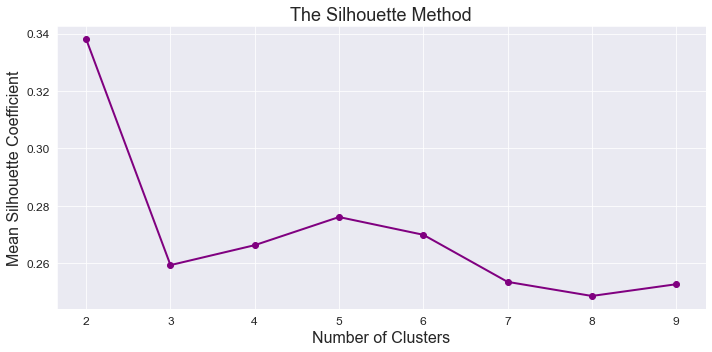

In [22]:
## Silhouette 
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(np.arange(2, max_clusters), sil_score, marker = 'o' , lw = 2, color = 'purple')
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Mean Silhouette Coefficient')
ax.set_title('The Silhouette Method')
plt.tight_layout()
plt.show()

5 appears to be the ideal number of clusters (k)

**Now KMeans clustering can be done!**

In [23]:
k = 5
df_feature = scaled

kmeans = KMeans(n_clusters = k, random_state = 10)
kmeans.fit_transform(df_feature)
customer_with_clusters = clean_customers.assign(cluster = kmeans.labels_)
print(customer_with_clusters.value_counts('cluster').sort_index())

print('Silhouette Score:', metrics.silhouette_score(df_feature, labels = kmeans.labels_))
cluster_info = customer_with_clusters.groupby('cluster').agg([np.mean])
print(cluster_info.round(1))


cluster
0    1574
1    3337
2    4000
3    2921
4    2622
dtype: int64
Silhouette Score: 0.27614911424041494
        viewed completed transactions money_spent
          mean      mean         mean        mean
cluster                                          
0          3.5       2.0         17.1        71.1
1          2.8       2.9          7.7       139.0
2          2.1       0.7          5.0        34.3
3          4.4       4.1         12.1       216.6
4          4.5       1.4          4.5        49.6


Above we can see how many customers belong to each cluster and the mean of each customer behavior by cluster grouping. The Silhouette score is 0.28. The Silhouette score ranges from -1 to 1 so 0.28 isn't bad, but could be better. 

#### Updating the model with PCA
PCA is a technique that helps us reduce the dimension of a dataset. When we run PCA on a data frame, new components are created. These components explain the maximum variance in the model.

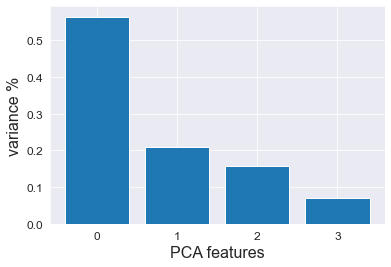

In [24]:
pca = PCA(n_components=4)
principalComponents = pca.fit_transform(df_feature)

features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_)
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

PCA_components = pd.DataFrame(principalComponents)

In [25]:
pca.explained_variance_ratio_

array([0.5641604 , 0.20955881, 0.15730168, 0.0689791 ])

Here, we can see that the first two features (0 and 1) account for a total of 77% of all of the variance. <br>
Now, we can try the model again with the first two principal components, and see if the ideal number of clusters changes. 

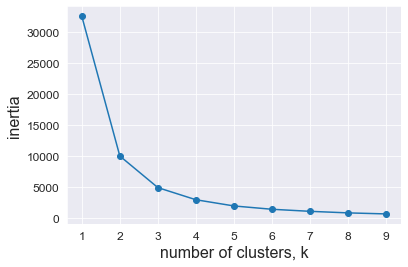

In [26]:
ks = range(1, 10)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(PCA_components.iloc[:,:1])
    inertias.append(model.inertia_)

plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

**k=5** still looks like the ideal number. Updating the Silhouette score with the first two PCA components

In [28]:
model = KMeans(n_clusters=4)
model.fit(PCA_components.iloc[:,:1])

# silhouette score
print(silhouette_score(PCA_components.iloc[:,:1], model.labels_, metric='euclidean'))

0.542211004221926


**0.54** is better than 0.28. <br>
To further test this, we can run a quick regression model to ensure the accruarcy. 

In [29]:
# Split data for train and test
X = scaled
Y = customer_with_clusters['cluster']
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 10)

In [30]:
# Multiclass logistic regression
clf = LogisticRegression()
clf.fit(x_train, y_train)

# Check test accurracy
y_predict = clf.predict(x_test)
acc_score = metrics.accuracy_score(y_test, y_predict) * 100
print("Test accuracy:", acc_score.round(2), "%")

Test accuracy: 99.38 %


In [31]:
# K-Nearest Neighbors Classificaiton
knn = KNeighborsClassifier(n_neighbors = 4)
knn.fit(x_train, y_train)

# Check test accuracy
y_predict = knn.predict(x_test)
acc_score = metrics.accuracy_score(y_test, y_predict) * 100
print("Test accuracy:", acc_score.round(2), "%")

Test accuracy: 98.24 %


****
### Initial Cluster Analysis

In [35]:
# Calculating the relative performace of cluster's attribute values compared to all customers as a population
cluster_mean = customer_with_clusters.groupby('cluster').mean()
population_mean = customer_with_clusters.mean()
relative_importance = (cluster_mean / population_mean[0 :-1]) - 1

# Reordering to see the importance of each cluster
importance_ranking = relative_importance.sum(axis = 1).sort_values(ascending = False).index.values
relative_importance = relative_importance.reindex(importance_ranking)

print(importance_ranking)

[3 0 1 4 2]


According to the importance rankings, cluster 3 is considered the most important, followed by cluster 0, cluster 1, and cluster 4. Cluster 2 is the least important. <br>
<br>
Now, the clusters can be addeed to the customer_behavior dataframe so we can begin the analysis.

In [36]:
# Merging the cluster dataframe with the customer beahvior 
# dataframe for customer analysis
new = pd.merge(customer_with_clusters, filtered_customers['received'], 
               left_index = True, right_index = True)

# Getting the means for each cluster for easy analysis
cluster_df = new.groupby('cluster').mean().round(2)

# Reordering based on importance_ranking
cluster_metrics = cluster_df.reindex(importance_ranking)

#### **Metrics for each Cluster**
To better understand each cluster of customers, we can created a few metrics:
##### Offer Metrics 
- **Offer Completion Rate (comp_rate)** - The number of offers completed compared to the total number of offers received. Does just receiving an offer have any effect of a customer making a purchase?
- **Offer Viewing Rate (view_rate)** - The number of completed offers compared to the number of offers viewed. Does a customer actually looking at the offer lead to a purchase?
- **Offer Effectiveness (effectiveness)** - The number of offers used to make a purchase. (offers completed/transactions)
  
##### Transactional Metrics 
- **Frequency (freq)** - How often the customer made a transaction (purchase) during the offer campaign, both with or without an offer. This is the same as the number of transactions.
- **Average Purchase Value (apv)** - Average money spent per transaction

In [37]:
# Offer metrics
cluster_metrics['comp_rate'] = (cluster_df['completed'] / cluster_df['received']).round(2)
cluster_metrics['view_rate'] = (cluster_df['completed'] / cluster_df['viewed']).round(2)
cluster_metrics['effectiveness'] = (cluster_df['completed'] / cluster_df['transactions']).round(2)

In [38]:
# Transactional metrics
cluster_metrics['freq'] = cluster_df['transactions']
cluster_metrics['apv'] = (cluster_df['money_spent'] / cluster_df['transactions']).round(2)

In [39]:
# Redorder index by importance ranking
cluster_summary = cluster_metrics.reindex(importance_ranking)
cluster_summary

,viewed,completed,transactions,money_spent,received,comp_rate,view_rate,effectiveness,freq,apv
cluster,,,,,,,,,,
3,4.43,4.08,12.08,216.58,5.08,0.80,0.92,0.34,12.08,17.93
0,3.51,2.02,17.09,71.06,4.67,0.43,0.58,0.12,17.09,4.16
1,2.83,2.87,7.68,138.97,4.14,0.69,1.01,0.37,7.68,18.10
4,4.54,1.45,4.51,49.62,5.03,0.29,0.32,0.32,4.51,11.00
2,2.14,0.67,4.99,34.25,3.88,0.17,0.31,0.13,4.99,6.86


### Analysis of the Clusters

As previously mentioned, cluster 3 is considered the most important, followed by cluster 0, cluster 1, and cluster 4. Cluster 2 is the least important.

**Cluster 3 - The MVP of Customers**
-  These customers have an offer completion rate of 80%. Of the offers viewed by this group, 92% of them were completed. However, their offer effectiveness rate is about 34%. This suggests that while they do use most of the offers they receive, they will still make transactions (purchases) without them. 
- This cluster makes a purchase about every 12 days each month, which is every 2 or 3 days. 
- They spend an average of almost $18 per purchase. 

**Cluster 0 - The Regulars**
- These customers have an offer completion rate of 43% and an offer effieciency rate is 12%. They only use 58% of the offers they view. This cluster uses about half of the offers they receive, and continue 88% of their purchases without any offers. This means that this group will make purchases with or without an offer.
- This cluster makes a purchase around 17 days each month, which is every 1 to 2 days. 
- Interestingly, they only spend about $ 4.16 on each purchase. This purchase is most likely a single "routine" drink.

**Cluster 1 - The Casual Customer**
- These customers have an offer completion rate of 69% with an offer effiencey rate of 37%. This suggests that while they are highly responsive to offers, they will still make transactions (purchases) without them. 
- What's interesting is that of the 37% that receive and complete the offers, the offer view rate over 100%. This suggests that they will blindly use an offer. For those customers in this cluster that actually use the offers, while in line to place an order, they will most likely quickly scan to see if they have received an offer. If they have, they will blindly use it without actually viewing the offer itself. 
- These customers make a purchase 7.68 days each month, or a little more than once a week. When they do make a purchase, they spend, on average, the most out of all of the clusters - $18.10

**Cluster 4 - The Viewers**
- These cluster of customers views the most offers (4.54) out of all of the cluster groupings, but only uses them on 29% of purchases. 
- They only make a purchase on 4.5 days each month, or about once a week. This is the lowest of any group. However, when these customers do make a purchase, they spend on average $ 11.00. 
- In short, this group makes the least amount of transactions, regardless of offers, but they spend the third most of any group. 

**Cluster 2 - The Least Likely Customer**
- This group has the lowest completion rate, viewing rate, and offer effectiveness. 
- They come in about once a week and spend around $ 6.86 on a purchase. 
- Future offers are not likely to effect this group.
****
